In [1]:
import torch
from dataset import PlantDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torch.optim as optim
import torch.nn as nn
import numpy as np
import sys
import time
import pandas as pd
from torchmetrics import Precision, Recall
import warnings
from torchvision.models import resnet18
warnings.filterwarnings('ignore')

In [5]:
pd.options.mode.chained_assignment = 'warn'
torch.cuda.empty_cache()

model = resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_classes = 4
model.fc = nn.Sequential(
    nn.Dropout(0.6),  
    nn.Linear(model.fc.in_features, num_classes))


batch_size = 32

trainset = PlantDataset('datasets/training_data.csv', 'images')
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=4)


testset = PlantDataset('datasets/valid_data.csv', 'images')

testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=4)

model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

precisions = []
precisions_val = []

recalls = []
val_recalls = []

losses = []
val_losses = []


metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

metric_precision_val = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall_val = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

EPOCHS = 20

In [6]:
for epoch in range(EPOCHS):
    recall = []
    precision = []

    recall_val = []
    precision_val = []

    training_loss = []
    start_time = time.time()
    elapsed_time = 0
    model.train() 
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = data
    
        
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, outputs = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)


        metric_precision(outputs, labels)
        metric_recall(outputs, labels)



        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.item())

        if (i + 1) % 5 == 0 or i == len(trainloader) - 1:
            elapsed_time = time.time() - start_time
            batches_done = i + 1
            batches_total = len(trainloader)
            batches_remaining = batches_total - batches_done
            time_per_batch = elapsed_time / batches_done
            estimated_time_remaining = time_per_batch * batches_remaining

            elapsed_time_minutes = elapsed_time / 60
            estimated_time_remaining_minutes = estimated_time_remaining / 60

            progress_message = f'Batch {i}/{len(trainloader)},Remaining: {estimated_time_remaining_minutes:.2f}min'
            sys.stdout.write("\r" + progress_message)
            sys.stdout.flush()

        

 
    model.eval()  
    val_loss = []
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            labels = torch.Tensor(labels)
            inputs = inputs.to('cuda:0')
            labels = labels.to('cuda:0')


            outputs = model(inputs)
            val_loss_crt = criterion(outputs, labels)

            _, outputs = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)

            metric_precision_val(outputs, labels)
            metric_recall_val(outputs, labels)


            val_loss.append(val_loss_crt.item())

    precision = metric_precision.compute()
    recall = metric_recall.compute()

    precision_val = metric_precision_val.compute()
    recall_val = metric_recall_val.compute()

    precisions.append(precision)
    precisions_val.append(precision_val)

    recalls.append(recall)
    val_recalls.append(recall_val)
    
    losses.append(np.mean(training_loss))
    val_losses.append(np.mean(val_loss))
    
    print(f'Epoch {epoch + 1}, Training loss: {np.mean(training_loss)} Validation Loss: {np.mean(val_loss)}')
    
    print(f'Epoch {epoch + 1}, Training Class 1: {precision[0]}, Class 2: {precision[1]}, Class 3: {precision[2]}, Class 4: {precision[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {precision_val[0]}, Class 2: {precision_val[1]}, Class 3: {precision_val[2]}, Class 4: {precision_val[3]}')

    print(f'Epoch {epoch + 1}, Training Class 1: {recall[0]}, Class 2: {recall[1]}, Class 3: {recall[2]}, Class 4: {recall[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {recall_val[0]}, Class 2: {recall_val[1]}, Class 3: {recall_val[2]}, Class 4: {recall_val[3]}')

    

print('Finished Training')
print('Finished Training')

Batch 36/37,Remaining: 0.00minEpoch 1, Training loss: 1.3843672475777566 Validation Loss: 1.2796110026790082
Epoch 1, Training Class 1: 0.3735955059528351, Class 2: 0.0357142873108387, Class 3: 0.3685446083545685, Class 4: 0.4378530979156494
Epoch 1, Validation Class 1: 0.2906666696071625, Class 2: 0.0, Class 3: 0.4299516975879669, Class 4: 0.3676975965499878
Epoch 1, Training Class 1: 0.40303030610084534, Class 2: 0.016949152573943138, Class 3: 0.39546599984169006, Class 4: 0.4100528955459595
Epoch 1, Validation Class 1: 0.33030304312705994, Class 2: 0.0, Class 3: 0.22418135404586792, Class 4: 0.5661375522613525
Batch 36/37,Remaining: 0.00minEpoch 2, Training loss: 1.1735592345971413 Validation Loss: 1.0856454333060774
Epoch 2, Training Class 1: 0.4153846204280853, Class 2: 0.0357142873108387, Class 3: 0.42276424169540405, Class 4: 0.48542457818984985
Epoch 2, Validation Class 1: 0.4514364004135132, Class 2: 0.0, Class 3: 0.4994232952594757, Class 4: 0.45068493485450745
Epoch 2, Train

In [7]:
torch.save(model.state_dict(),'models/model_resnet18.pth')
df = pd.DataFrame()
df['loss'] = np.array(losses)
df['val_loss'] = np.array(val_losses)

df['recall'] = [list(recall.cpu().numpy()) for recall in recalls]
df['val_recall'] = [list(val_recall.cpu().numpy()) for val_recall in val_recalls]

df['precision'] = [list(precision.cpu().numpy()) for precision in precisions] 
df['val_precision'] = [list(val_precision.cpu().numpy()) for val_precision in precisions_val]

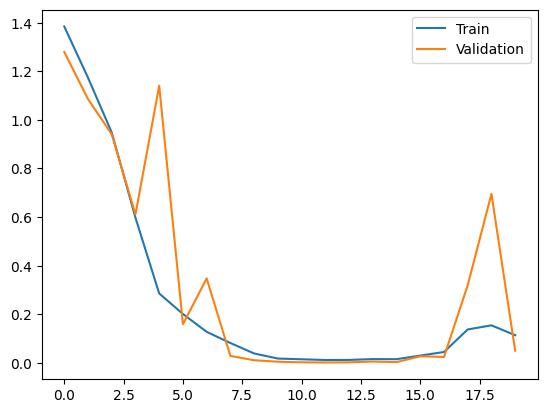

In [8]:
plt.plot(df['loss'], label='Train')
plt.plot(df['val_loss'], label='Validation')
plt.legend()
plt.show()

In [ ]:



dataset = PlantDataset(data_path='test_data')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

test_report(model, dataloader)